In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [232]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
da.load_results()

Initializing T1024 ...
casp_da/T1024_win4-5-6-7
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [ ]:
#T1024: --------HHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEE-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHH-----------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------EEEE--HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--
#T1030: -HHHHHHHHHHHHHHH-------HHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHH----------EEHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH------HHHHHHHHHHHHHHHHHHH---------HHHHHHHHH-----------EE----HHHHHHHHHHHHHHHHHHHHHH------

In [4]:
ss = '--------HHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEE-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--HHHHHHHHHHHHHHHHHHHHH-----------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------EEEE--HHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--'

In [28]:
da.sequence[da.winsize_ctxt//2:len(da.sequence) - da.winsize_ctxt // 2]

'FWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITGILLALSAVATFVAGILAGFFADRNGRKPVMVFGTIIQLLGAALAIASNLPGHVNPWSTFIAFLLISFGYNFVITAGNAMIIDASNAENRKVVFMLDYWAQNLSVILGAALGAWLFRPAFEALLVILLLTVLVSFFLTTFVMTETFKPTVKVDNIFQAYKTVLQDKTYMIFMGANIATTFIIMQFDNFLPVHLSNSFKTITFWGFEIYGQRMLTIYLILACVLVVLLMTTLNRLTKDWSHQKGFIWGSLFMAIGMIFSFLTTTFTPIFIAGIVYTLGEIVYTPSVQTLGADLMNPEKIGSYNGVAAIKMPIASILAGLLVSISPMIKAIGVSLVLALTEVLAIILVLVAVNRHQKTKLNLEVL'

In [233]:
# jpred_map = {'H': 0, 'E': 1, 'c': 2, 'C': 2, '-': 3}
jpred_map = {'H': 0, 'E': 1, '-': 2}
# H = alpha helix, E = beta strand, - = other
jpred_map_inv = {v: k for k, v in jpred_map.items()}
jpred = []
j = 0
i = 0
while(i < len(da.xray_phi_psi)):
    row = da.xray_phi_psi.iloc[i]
    if da.sequence[j] == row['res']:
        jpred.append(jpred_map[ss[j]])
        j += 1
        i += 1
    else:
        j += 1
da.xray_phi_psi['jpred'] = jpred

In [314]:
from lib.across_window_utils import *
from lib.utils import get_phi_psi_dist

In [315]:
# Beta sheet: (phi, psi) (-135, 135)
# Alpha helix: (phi, psi) (-60, -45)
# - angles that sum to -105 (-90, -15) to (-70, -35)
# left-handed helix: (phi, psi) (60, 45)
from scipy import stats

def get_target_cluster_ss(phi_psi_dist, clusters, precomputed_dists, ss_seq):
    ss_pred_seq = stats.mode(ss_seq)[0]
    # TODO handle left-handed helix and coil
    if ss_pred_seq == 0:
        # alpha helix
        ideal_target = np.array([-60, -45]) # or [60, 45] for left-handed helix
    elif ss_pred_seq == 1:
        # beta strand
        ideal_target = np.array([-135, 135])
    else:
        # other (coil)
        pass
    w = phi_psi_dist.values.shape[1] // 2
    ideal_target = ideal_target[[0]*w + [1]*w]

    medoids = []
    cs = np.unique(clusters)
    for c in cs:
        medoids.append(get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, c))
    medoids = np.array(medoids)
    nearest_cluster = cs[np.linalg.norm(diff(medoids, ideal_target), axis=1).argmin()]
    return nearest_cluster

def get_target_cluster_icov_ss(phi_psi_dist, precomputed_dists, clusters, ss_seq):
    target_cluster = get_target_cluster_ss(phi_psi_dist, clusters, precomputed_dists, ss_seq)
    cluster_medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, target_cluster)
    icov = estimate_icov(phi_psi_dist[clusters == target_cluster], cluster_medoid)
    if icov is None:
        return None, None, None
    return target_cluster, cluster_medoid, icov

In [318]:
MIN_SAMPLES = [100, 20, 1, 1]
MIN_CLUSTER_SIZES = [20, 5, 1, 1]


ins = da
center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
winsize_ctxt = ins.queries[-1].winsize
seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

for i,seq_ctxt in enumerate(seqs_for_window):
    print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq_ctxt}')
    if 'X' in seq_ctxt:
        print(f'\tSkipping {seq_ctxt} - X in sequence')
        continue
    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    for j in info:
        print(f'\tWin {j[0]}: {j[1]} - {j[2]} samples')

    q = ins.queries[0]
    xrays = get_xrays_window(ins, q, seq_ctxt)
    preds = get_preds_window(ins, q, seq_ctxt)
    afs = get_afs_window(ins, q, seq_ctxt)
    pos = da.xray_phi_psi.loc[da.xray_phi_psi.seq_ctxt == seq_ctxt, 'pos']
    if pos.shape[0] > 1:
        # TODO handle case if this is the second appearance of this seq_ctxt (find pos of the second appearance)
        pass
    pos = pos.iloc[0]

    ss_seq = ins.get_seq_ctxt(da.xray_phi_psi['jpred'], pos).values
    print(f'\tSS Pred: {"".join([jpred_map_inv[s] for s in ss_seq])}')

    if xrays.shape[0] != q.winsize*2:
        print(f"Xray data for {seq_ctxt} is incomplete")
        continue
    if preds is None or preds.shape[0] == 0:
        print(f"No predictions for {seq_ctxt}")
        continue
    if afs is None or afs.shape[0] != q.winsize*2:
        print(f"AF data for {seq_ctxt} is incomplete")
        continue

    phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
    if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
        print(f"No pdbmine data for {seq_ctxt}")
        continue
    if phi_psi_dist.shape[0] < MIN_SAMPLES[0]:
        print(f"Not enough pdbmine data for {seq_ctxt}")
        continue

    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    if n_clusters == 0:
        print(f"No clusters found for {seq_ctxt}")
        continue
    precomputed_dists, phi_psi_dist_v, clusters = filter_precomputed_dists(precomputed_dists, phi_psi_dist_v, clusters)
    target_cluster, target, icov = get_target_cluster_icov(phi_psi_dist_v, precomputed_dists, clusters, afs)
    target_cluster, target, icov = get_target_cluster_icov_ss(phi_psi_dist_v, precomputed_dists, clusters, ss_seq)
    if icov is None:
        print(f"Error calculating mahalanobis distance for {seq_ctxt}")
        continue

    xray_maha = calc_da_for_one_window(xrays, target, icov)
    preds_maha = calc_da_window(preds, target, icov)

    print(f'\t{i}: {xray_maha:.2f}, {np.nanmean(preds_maha):.2f}')

    # Distance from preds to xray
    col_name = f'da'
    ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, col_name] = xray_maha

    view = ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].reset_index().set_index('protein_id')
    view.loc[preds.index, col_name] = preds_maha
    ins.phi_psi_predictions.loc[view['index'], col_name] = view.set_index('index')[col_name]
    break

0/372: WNLDKNL
	Win 4: LDKN - 2427 samples
	Win 5: NLDKN - 95 samples
	Win 6: NLDKNL - 8 samples
	Win 7: WNLDKNL - 0 samples
	SS Pred: HHHHHHH
	0: 25.60, 22.93


In [228]:
win4 = phi_psi_dist[phi_psi_dist.seq.str.len() == 4].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win5 = phi_psi_dist[phi_psi_dist.seq.str.len() == 5].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win6 = phi_psi_dist[phi_psi_dist.seq.str.len() == 6].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)
win7 = phi_psi_dist[phi_psi_dist.seq.str.len() == 7].iloc[:, 1:-3].values.reshape(-1, 2,4).transpose(0,2,1)

In [157]:
def plot(matches):
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(matches.shape[0]):
        ax.scatter(matches[i,:,0]+np.arange(4)*360, matches[i,:,1])
        ax.plot(matches[i,:,0]+np.arange(4)*360, matches[i,:,1])
    ax.set_xlim(-180, 360*4 - 180)
    ax.set_ylim(-180, 180)
    ax.set_xticks(np.arange(-180, 360*4, 180))
    ax.set_xticklabels(np.mod(np.arange(-180, 360*4, 180), 360));
    for j in range(4):
        ax.vlines(j*360-180, -180, 180, color='black', alpha=0.5, linestyles='--')

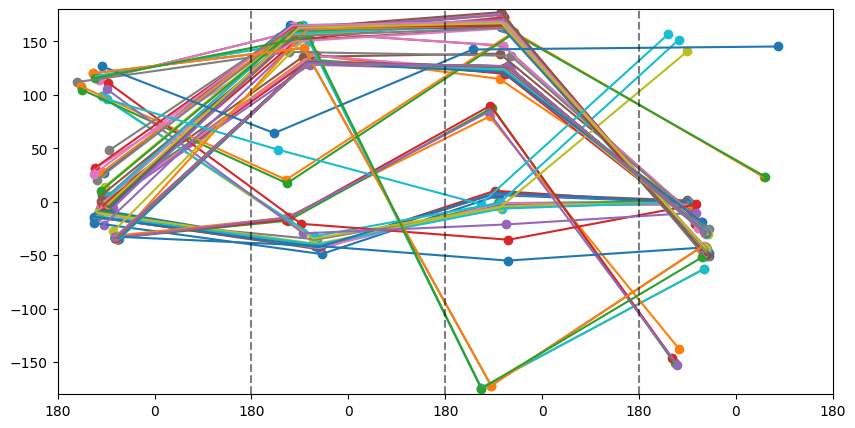

In [158]:
plot(win5)

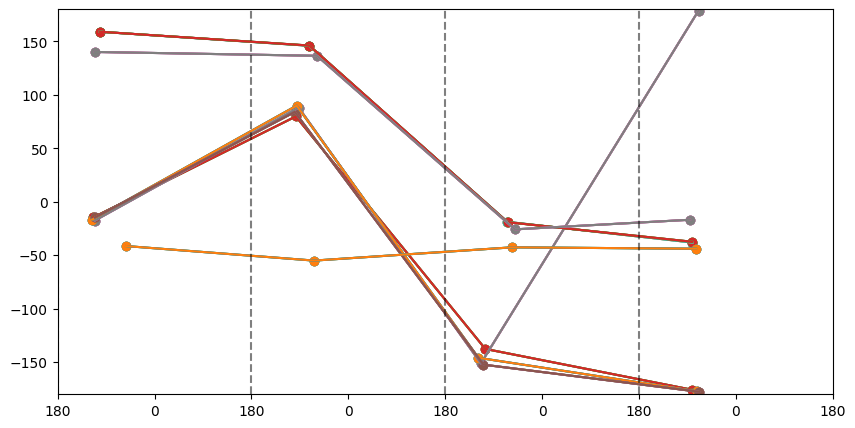

In [229]:
plot(win6)